In [1]:
#!pip install plotly

In [2]:
# Standard Imports
import nltk
import pandas                        as pd
import numpy                         as np
import seaborn                       as sns
import matplotlib.pyplot             as plt
import re
import ftfy
from IPython.display                 import display_html
from IPython.core.display            import display, HTML

# Proprocessing, Modeling, & Evaluation
from nltk.corpus                     import stopwords
from nltk.stem                       import WordNetLemmatizer
from nltk.tokenize                   import RegexpTokenizer 
from sklearn.ensemble                import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection         import GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics                 import accuracy_score, recall_score, roc_auc_score, matthews_corrcoef,roc_curve,precision_score,auc,make_scorer,precision_recall_curve
from sklearn.pipeline                import Pipeline
from sklearn.svm                     import SVC
#from sklearn.tree                    import DecisionTreeClassifier
from sklearn                         import model_selection
#from xgboost                         import XGBClassifier
from sklearn.feature_selection       import chi2,SelectKBest
   

# Custom Modules
import graphs
import metrics


# Notebook settings & styles
sns.set(style = "white", palette = "deep")
display(HTML("<style>.container { width:95% !important; }</style>"))
%matplotlib inline

In [3]:
Annotated_Sample = pd.read_csv('./Reddit Data/All/Reddit Eczema_All_20201201_Sample_Annotated.csv', encoding = "iso-8859-1" )


In [4]:
# Downloading the default stopwords

##nltk.download("stopwords");

# Adding our stopwords to the English set

##new_stopwords = ["like", "just", "make", "cook","use", "chicken", "recipe", "sauce"]

stop_words     = stopwords.words('english')

##stopwords.extend(new_stopwords)

# Instantiating the lemmatizier and tokenizer
# The tokenizer will only keep text
## nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
tokenizer  = RegexpTokenizer(r'\w+')

In [5]:
def cleaning_data(dataframe):
   
    if 'Annotation' in dataframe :
        dataframe["label"] = dataframe["Annotation"].apply(lambda x: 1 if x == "I" else 0)
    
    #Annotated_Sample.drop(columns=['Annotation'],inplace=True)
    dataframe.rename(columns={'Author':'author'},inplace=True)
    
    #lower case
    
    dataframe["body"] = dataframe["body"].astype(str)
    
    dataframe["body"] = dataframe["body"].str.lower()
    
    dataframe ["body"] = dataframe ["body"].map(ftfy.fix_encoding)
    
    #remove URL
    dataframe["body"] = dataframe["body"].str.replace("http\S+", "")
    
    #remove none letters
    
    dataframe["body"] =  dataframe["body"].apply(lambda x: re.sub(r'[^a-z]',' ',str(x)))
    
    # Setting up the lemmatizer

    lemmatized_posts = []

    for post in dataframe["body"]:
        tokens = tokenizer.tokenize(post)
        post   = [lemmatizer.lemmatize(post) for post in tokens]
        lemmatized_posts.append(" ".join(post))

    # Appending the lemmatized posts to the dataframe

    dataframe["lemmatized_text"] = lemmatized_posts

    # Checking the head of the dataframe
    #dataframe.head()

    return dataframe


In [6]:
Annotated_Sample = cleaning_data(Annotated_Sample)
Annotated_Sample.head()

,author,body,Annotation,label,lemmatized_text
0,touchyfeelies,thanks,I,1,thanks
1,Replacementheart,oh wow i m local and i just moved here haha,I,1,oh wow i m local and i just moved here haha
2,Grumpy_Frenchman,but if you never stop,I,1,but if you never stop
3,UnhingedMom,google calendar same place i track the rest o...,I,1,google calendar same place i track the rest of...
4,princesskailynkitten,wow very thorough thank you so much for inc...,I,1,wow very thorough thank you so much for includ...


### CountVectorizer

Convert a collection of text documents to a matrix of token counts

<https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html>

In [7]:
vec_lem = CountVectorizer(ngram_range =(1,2),stop_words = stop_words,min_df=2,max_features=None, binary=True)

vec_sample_lem     = vec_lem.fit_transform(Annotated_Sample["lemmatized_text"])

sample_vectorized_lem     = pd.DataFrame(vec_sample_lem.toarray(), columns = vec_lem.get_feature_names())



sum=sample_vectorized_lem.sum().sort_values(ascending=False)
sum.head()

eczema    308
skin      230
wa        212
like      210
get       183
dtype: int64

In [8]:
X = sample_vectorized_lem.drop("label",axis=1)
y = Annotated_Sample["label"]
chi_scores = chi2(X, y)

s = pd.Series(chi_scores[0],index = X.columns)
p = pd.Series(chi_scores[1],index = X.columns)
chi= pd.concat([s, p,sum], axis=1)

chi.sort_values(by=0,ascending = False , inplace = True)
chi.head(500)



,0,1,2
eczema,64.120910,1.170130e-15,308
skin,40.430153,2.037719e-10,230
thank,30.212638,3.871783e-08,36
use,29.438653,5.771495e-08,158
also,29.152150,6.691146e-08,146
...,...,...,...
hear,1.992069,1.581247e-01,16
someone,1.982343,1.591438e-01,27
eucerin,1.944079,1.632263e-01,9
prednisone,1.944079,1.632263e-01,9


In [9]:
#sample_vectorized_lem ["label"] = Annotated_Sample["label"]
#sample_vectorized_lem[sample_vectorized_lem.columns[1:]].corr()['label'][:]
X_new = SelectKBest(chi2, k=20).fit_transform(X, y)

print(X_new.shape)

(1109, 20)


### TfidfVectorizer

TF-IDF (term frequency-inverse document frequency) was invented for document search and information retrieval. It works by increasing proportionally to the number of times a word appears in a document, but is offset by the number of documents that contain the word. 


<https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html>

In [10]:
tvec_lem = TfidfVectorizer(ngram_range =(1,2),stop_words = stop_words,max_features=None)

tvec_sample_lem     = tvec_lem.fit_transform(Annotated_Sample["lemmatized_text"])

tsample_vectorized_lem     = pd.DataFrame(tvec_sample_lem.toarray(),columns = tvec_lem.get_feature_names())

tsample_vectorized_lem.T[0].sort_values(ascending=False)

thanks             1.0
zyrtec wa          0.0
friendly cheap     0.0
friction enough    0.0
friday             0.0
                  ... 
provide hope       0.0
provide use        0.0
provider           0.0
provider anthem    0.0
abbvie             0.0
Name: 0, Length: 30834, dtype: float64

# Modelling

__Create Test and Training data split__

In [11]:
X = Annotated_Sample["lemmatized_text"]
y = Annotated_Sample["label"]

# The random state ensures reproducability
# The stratify argument preserves the distribution of classes

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state = 42,
                                                    stratify     = y)

## Support Vector Classifier

A support vector machine (in this case a classifier) is at its core a linear model. However, instead of running like a logistic regression, it seeks to linearly separate the data. To do that, it uses a kernel to raise the data into n-dimensional space. It then uses a line, plane (3-dimensional line), or hyperplane (greater than 3-dimensions) to delineate the data



### Count Vector

In [12]:
# Setting up the count vector pipeline

cvec_svc_pipe = Pipeline([("cvec", CountVectorizer()),
                          ("bestf",SelectKBest()),
                          ("svc", SVC())])




#### Count Vector + SVM Kernel - Linear 


In [13]:
# Setting CVEC and pipe hyperparameters
cvec_linear_pipe_params = {"cvec__max_features": [None], 
                    "cvec__ngram_range" : [(1,2)], 
                    "cvec__stop_words"  : [stop_words],
                    "cvec__binary"      : [True],
                    "cvec__min_df"      : [2],
                    "bestf__score_func" : [chi2],
                    "bestf__k"          : [500],       
                    "svc__C"            : [1],
                    "svc__kernel"       : ["linear"],
                    "svc__probability"  : [True]}

                   
# Instantiating the grid search

cvec_linear_svc_gs = GridSearchCV(cvec_svc_pipe, 
                           param_grid = cvec_linear_pipe_params, 
                           cv         = 10,
                           scoring    = 'roc_auc'
                           )

                    
# Fitting the model to the training data

cvec_linear_svc_gs.fit(X_train, y_train)

# print best parameter after tuning 
print(cvec_linear_svc_gs.best_params_) 

{'bestf__k': 500, 'bestf__score_func': <function chi2 at 0x7f8a3b6a2a60>, 'cvec__binary': True, 'cvec__max_features': None, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 2), 'cvec__stop_words': ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 

In [14]:
results_linear = pd.DataFrame(cvec_linear_svc_gs.cv_results_)

#results.head()
results_linear = results_linear.sort_values(by='std_test_score')

#results_linear.round(3).head(20)
results_linear[['param_bestf__k','param_cvec__binary','param_svc__C', 'param_svc__kernel','mean_test_score','std_test_score','rank_test_score']].round(3).head(20)

,param_bestf__k,param_cvec__binary,param_svc__C,param_svc__kernel,mean_test_score,std_test_score,rank_test_score
0,500,True,1,linear,0.91,0.035,1


In [15]:
# Generating training predictions

cvec_linear_train_preds = cvec_linear_svc_gs.predict(X_train)

cvec_linear_train_score = cvec_linear_svc_gs.decision_function(X_train)

# Training metrics

summary_training_linear=metrics.binary_classification_summary(y_train, cvec_linear_train_preds,cvec_linear_train_score,'summary_training_linear')

In [16]:
summary_training_linear.head()

,summary_training_linear
Accuracy,0.980746
Sensitivity,0.986486
Specificity,0.979502
AUROC,0.996617
Matthews Corr. Coef.,0.937329


#### Count Vector + SVM Kernel - rbf 


In [17]:
# Setting CVEC and pipe hyperparameters

cvec_rbf_pipe_params = {"cvec__max_features": [None], 
                    "cvec__ngram_range" : [(1,2)], 
                    "cvec__stop_words"  : [stop_words],
                    "cvec__binary"      : [True],
                    "cvec__min_df"      : [2],
                    "bestf__score_func" : [chi2],
                    "bestf__k"          : [300], 
                    "svc__C"            : [1.5],
                    "svc__gamma"        : [0.2],
                    "svc__kernel"       : ["rbf"],
                    "svc__probability"  : [True]}

                    
# Instantiating the grid search

cvec_rbf_svc_gs = GridSearchCV(cvec_svc_pipe, 
                           param_grid = cvec_rbf_pipe_params, 
                           cv         = 10,
                           scoring    = 'roc_auc'
                           )

                    
# Fitting the model to the training data

cvec_rbf_svc_gs.fit(X_train, y_train)

# print best parameter after tuning 
print(cvec_rbf_svc_gs.best_params_) 

{'bestf__k': 300, 'bestf__score_func': <function chi2 at 0x7f8a3b6a2a60>, 'cvec__binary': True, 'cvec__max_features': None, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 2), 'cvec__stop_words': ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 

In [18]:
results_rbf = pd.DataFrame(cvec_rbf_svc_gs.cv_results_)
results_rbf = results_rbf.sort_values(by='std_test_score')
#results_rbf.head()

results_rbf[['param_bestf__k','param_cvec__binary','param_svc__C', 'param_svc__kernel','param_svc__gamma','mean_test_score','std_test_score', 'rank_test_score']].round(3).head(20)

,param_bestf__k,param_cvec__binary,param_svc__C,param_svc__kernel,param_svc__gamma,mean_test_score,std_test_score,rank_test_score
0,300,True,1.5,rbf,0.2,0.928,0.034,1


In [19]:
# Generating training predictions

cvec_rbf_train_preds = cvec_rbf_svc_gs.predict(X_train)

cvec_rbf_train_score = cvec_rbf_svc_gs.decision_function(X_train)

# Training metrics

summary_training_rbf=metrics.binary_classification_summary(y_train, cvec_rbf_train_preds,cvec_rbf_train_score,'summary_training_rbf')



In [20]:
# Generating a confusion matrix on the test results

metrics.confusion_matrix_dataframe(y_train, 
                                   cvec_rbf_train_preds,
                                   columns = ["Predicted Related", "Predicted Irrelated"],
                                   index   = ["Actual Related", "Actual Irrelated"])

,Predicted Related,Predicted Irrelated
Actual Related,667,16
Actual Irrelated,8,140


In [21]:
summary_training_rbf.head()

,summary_training_rbf
Accuracy,0.971119
Sensitivity,0.945946
Specificity,0.976574
AUROC,0.988554
Matthews Corr. Coef.,0.903863


### Fining Tuning with Threshold Moving

In [22]:
"""
# calculate fscore
fscore = (2*p*r)/(p+r)
#locate the index of the largest fscore
ix=np.argmax(fscore)
print('Best Threshold=%f, F-score=%.3f'%(thresholds[ix],fscore[ix]))

# plot the precision recall curve

plt.plot(r, p, marker='.', label='')
plt.scatter(r[ix],p[ix],marker='X',color='red',label='Best')
plt.xlabel('Recall')
plt.ylabel('Precision')
"""

"\n# calculate fscore\nfscore = (2*p*r)/(p+r)\n#locate the index of the largest fscore\nix=np.argmax(fscore)\nprint('Best Threshold=%f, F-score=%.3f'%(thresholds[ix],fscore[ix]))\n\n# plot the precision recall curve\n\nplt.plot(r, p, marker='.', label='')\nplt.scatter(r[ix],p[ix],marker='X',color='red',label='Best')\nplt.xlabel('Recall')\nplt.ylabel('Precision')\n"

In [23]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):

    fscore = (2*precisions*recalls)/(precisions+recalls)
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.plot(thresholds, fscore[:-1], "k:", label="fscore")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    ix=np.argmax(fscore)
    plt.scatter(thresholds[ix],fscore[ix],marker='X',color='red',label='Best')
    print('Best Threshold=%f, F-score=%.3f'%(thresholds[ix],fscore[ix]))
    threshold_= thresholds[ix]
    return threshold_


In [24]:
# This function allows for dataframes to be displayed side-by-side

def display_side_by_side(*args):
    html_str = ''
    for df in args:
        html_str += df.to_html()
    display_html(html_str.replace('table', 'table style="display:inline"'), raw = True)

In [25]:
def adjusted_prediction(y_scores,t):
    return [1 if y >= t else 0 for y in y_scores]

#### Linear Kernel

In [26]:
precision_linear, recall_linear, thresholds_linear = precision_recall_curve(y_train, cvec_linear_train_score)

Best Threshold=0.036185, F-score=0.951


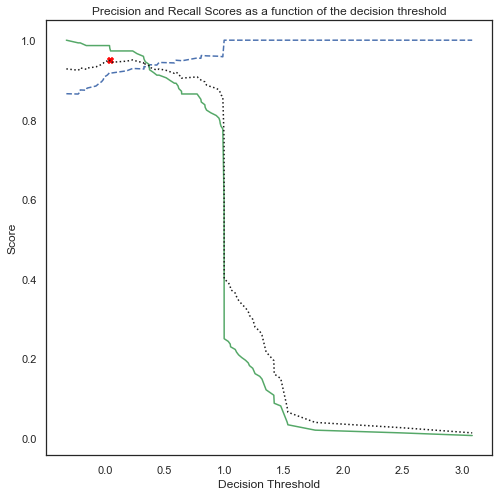

In [27]:
# plot the precion, recall and f score a function of the decision threshold based on the linear kernal

adjusted_threshold_linear=plot_precision_recall_vs_threshold(precision_linear, recall_linear, thresholds_linear)

In [28]:
print(adjusted_threshold_linear)

0.03618467146951554


In [29]:
cvec_linear_train_new_preds=adjusted_prediction(cvec_linear_train_score,adjusted_threshold_linear)

In [30]:
# Generating a new confusion matrix on the training results

metrics.confusion_matrix_dataframe(y_train, 
                                   cvec_linear_train_new_preds,
                                   columns = ["Predicted Related (Ajusted)", "Predicted Irrelated(Ajusted)"],
                                   index   = ["Actual Related", "Actual Irrelated"])

,Predicted Related (Ajusted),Predicted Irrelated(Ajusted)
Actual Related,670,13
Actual Irrelated,2,146


In [31]:
summary_training_linear_new=metrics.binary_classification_summary(y_train, cvec_linear_train_new_preds,cvec_rbf_train_score,'summary_training_linear_adjusted')

#### rbf Kernal

In [32]:
precision_rbf, recall_rbf, thresholds_rbf= precision_recall_curve(y_train, cvec_rbf_train_score)


Best Threshold=0.060153, F-score=0.924


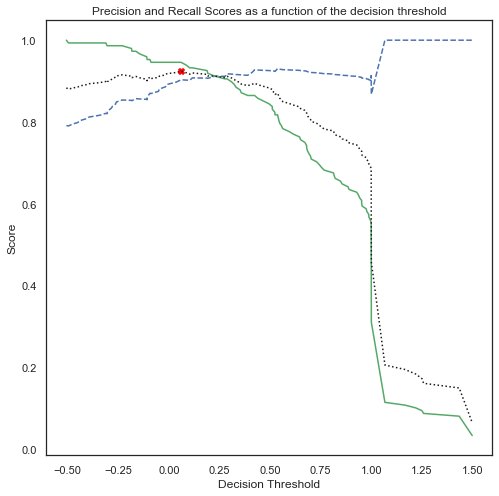

In [33]:
# plot the precion, recall and f score a function of the decision threshold based on the rbf kernal

adjusted_threshold_rbf=plot_precision_recall_vs_threshold(precision_rbf, recall_rbf, thresholds_rbf)

In [34]:
print(adjusted_threshold_rbf)

0.06015348560655154


In [35]:
cvec_rbf_train_new_preds=adjusted_prediction(cvec_rbf_train_score,adjusted_threshold_rbf)

In [36]:
# Generating a confusion matrix on the test results

metrics.confusion_matrix_dataframe(y_train, 
                                   cvec_rbf_train_new_preds,
                                   columns = ["Predicted Related (Ajusted)", "Predicted Irrelated(Ajusted)"],
                                   index   = ["Actual Related", "Actual Irrelated"])

,Predicted Related (Ajusted),Predicted Irrelated(Ajusted)
Actual Related,668,15
Actual Irrelated,8,140


In [37]:
summary_training_rbf_new=metrics.binary_classification_summary(y_train, cvec_rbf_train_new_preds,cvec_rbf_train_score,'summary_training_rbf_adjusted')


In [38]:
display_side_by_side(summary_training_linear,summary_training_linear_new,summary_training_rbf,summary_training_rbf_new)

,summary_training_linear
Accuracy,0.980746
Sensitivity,0.986486
Specificity,0.979502
AUROC,0.996617
Matthews Corr. Coef.,0.937329
,summary_training_linear_adjusted
Accuracy,0.981949
Sensitivity,0.986486
Specificity,0.980966
AUROC,0.988554


### Validating on test dataset

#### Linear Kernel

In [39]:
# Generating test predictions based on linear kernel

cvec_linear_svc_preds_test       = cvec_linear_svc_gs.predict(X_test)

cvec_linear_svc_score_test       = cvec_linear_svc_gs.decision_function(X_test)


Best Threshold=0.064287, F-score=0.707


0.06428677405873207

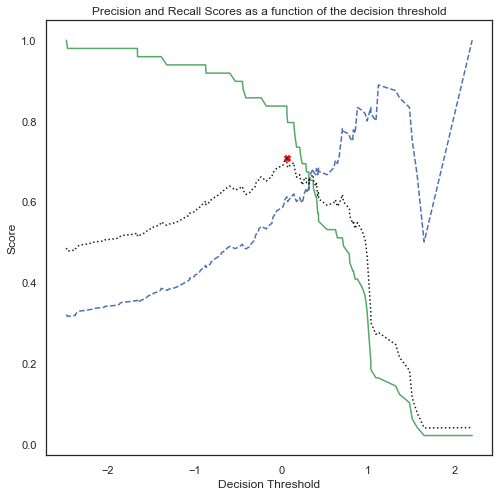

In [40]:
precision_linear_test, recall_linear_test, threshold_linear_test = precision_recall_curve(y_test, cvec_linear_svc_score_test)

# use the same p, r, thresholds that were previously calculated
plot_precision_recall_vs_threshold(precision_linear_test, recall_linear_test, threshold_linear_test)

In [41]:
cvec_linear_svc_preds_test_new=adjusted_prediction(cvec_linear_svc_score_test,adjusted_threshold_linear)

In [42]:
# Generating a confusion matrix on the test results based on linear kernal

metrics.confusion_matrix_dataframe(y_test, 
                                   cvec_linear_svc_preds_test,
                                   columns = ["Predicted Related", "Predicted Irrelated"],
                                   index   = ["Actual Related", "Actual Irrelated"])

,Predicted Related,Predicted Irrelated
Actual Related,200,29
Actual Irrelated,8,41


In [43]:
# Generating a confusion matrix on the test results based on linear kernal

metrics.confusion_matrix_dataframe(y_test, 
                                   cvec_linear_svc_preds_test_new,
                                   columns = ["Predicted Related (Ajusted)", "Predicted Irrelated(Ajusted)"],
                                   index   = ["Actual Related", "Actual Irrelated"])

,Predicted Related (Ajusted),Predicted Irrelated(Ajusted)
Actual Related,202,27
Actual Irrelated,8,41


In [44]:
summary_linear_test = metrics.binary_classification_summary(y_test, cvec_linear_svc_preds_test,cvec_linear_svc_score_test,'summary_linear_test')

In [45]:
summary_linear_test_new = metrics.binary_classification_summary(y_test, cvec_linear_svc_preds_test_new,cvec_linear_svc_score_test,'summary_linear_test_adjusted')

In [46]:
display_side_by_side(summary_linear_test,summary_linear_test_new)

,summary_linear_test
Accuracy,0.866906
Sensitivity,0.836735
Specificity,0.873362
AUROC,0.921576
Matthews Corr. Coef.,0.623380
,summary_linear_test_adjusted
Accuracy,0.874101
Sensitivity,0.836735
Specificity,0.882096
AUROC,0.921576


#### rbf Kernel

In [47]:
# Generating test predictions based on linear kernel

cvec_rbf_svc_preds_test       = cvec_rbf_svc_gs.predict(X_test)

cvec_rbf_svc_score_test       = cvec_rbf_svc_gs.decision_function(X_test)



Best Threshold=0.035307, F-score=0.737


0.03530740959126755

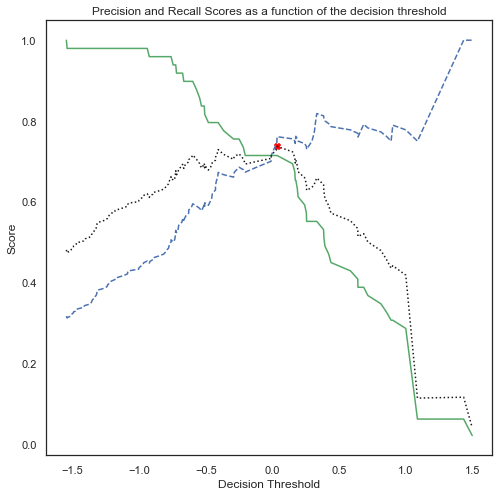

In [48]:
precision_rbf_test, recall_rbf_test, threshold_rbf_test = precision_recall_curve(y_test, cvec_rbf_svc_score_test)

# use the same p, r, thresholds that were previously calculated
plot_precision_recall_vs_threshold(precision_rbf_test, recall_rbf_test, threshold_rbf_test)

In [49]:
cvec_rbf_svc_preds_test_new=adjusted_prediction(cvec_rbf_svc_score_test,adjusted_threshold_rbf)

In [50]:
# Generating a confusion matrix on the test results based on linear kernal

metrics.confusion_matrix_dataframe(y_test, 
                                   cvec_rbf_svc_preds_test,
                                   columns = ["Predicted Related", "Predicted Irrelated"],
                                   index   = ["Actual Related", "Actual Irrelated"])

,Predicted Related,Predicted Irrelated
Actual Related,216,13
Actual Irrelated,14,35


In [51]:
# Generating a confusion matrix on the test results based on linear kernal

metrics.confusion_matrix_dataframe(y_test, 
                                   cvec_rbf_svc_preds_test_new,
                                   columns = ["Predicted Related (Ajusted)", "Predicted Irrelated(Ajusted)"],
                                   index   = ["Actual Related", "Actual Irrelated"])

,Predicted Related (Ajusted),Predicted Irrelated(Ajusted)
Actual Related,218,11
Actual Irrelated,15,34


In [52]:
summary_rbf_test = metrics.binary_classification_summary(y_test, cvec_linear_svc_preds_test,cvec_linear_svc_score_test,'summary_rbf_test')

In [53]:
summary_rbf_test_new = metrics.binary_classification_summary(y_test, cvec_linear_svc_preds_test_new,cvec_linear_svc_score_test,'summary_rbf_test_adjusted')

In [54]:
display_side_by_side(summary_linear_test,summary_linear_test_new,summary_rbf_test,summary_rbf_test_new)

,summary_linear_test
Accuracy,0.866906
Sensitivity,0.836735
Specificity,0.873362
AUROC,0.921576
Matthews Corr. Coef.,0.623380
,summary_linear_test_adjusted
Accuracy,0.874101
Sensitivity,0.836735
Specificity,0.882096
AUROC,0.921576


**TFIDF Vectorizer**


In [ ]:
# Setting up the pipeline

tvec_svc_pipe = Pipeline([("tvec", TfidfVectorizer()), 
                         ("svc", SVC())])

# Setting TFIDF and pipe hyperparameters
"""
tvec_pipe_params = {"tvec__max_features": [250], 
                    "tvec__ngram_range" : [(1,2)], 
                    "tvec__stop_words"  : [stopwords],
                    "tvec__min_df"      : [2],
                    "svc__C"            : [2,2.5,3.5],
                    "svc__kernel"       : ["linear","rbf"],
                    "svc__gamma"        : [0.5,0.75,1]}



"""

tvec_pipe_params = {"tvec__max_features": [250], 
                    "tvec__ngram_range" : [(1,2)], 
                    "tvec__stop_words"  : [stop_words],
                    "tvec__min_df"      : [2],
                    "svc__C"            : [2.14,2.15,2.16],
                    "svc__kernel"       : ["linear"],
                    "svc__gamma"        : ['scale'],
                    "svc__probability"  : [True]}
                    
# Instantiating the grid search

tvec_svc_gs = GridSearchCV(tvec_svc_pipe, 
                           param_grid = tvec_pipe_params, 
                           cv         = 10)


# Fitting the model to the training data

tvec_svc_gs.fit(X_train, y_train);

# print best parameter after tuning 
print(tvec_svc_gs.best_params_) 


In [ ]:
# Generating training predictions

tvec_svc_train_preds = tvec_svc_gs.predict(X_train)
tvec_svc_train_score = tvec_svc_gs.decision_function(X_train)

# Training metrics

metrics.binary_classification_summary(y_train, tvec_svc_train_preds,tvec_svc_train_score)

In [ ]:
# Generating test predictions

tvec_svc_preds       = tvec_svc_gs.predict(X_test)

tvec_svc_score       = tvec_svc_gs.decision_function(X_test)

tvec_svc_proba       = tvec_svc_gs.predict_proba(X_test)[:,1]
#tvec_svc_proba.shape

# plot test roc_curve#1
graphs.roc_curve(model_prob  = tvec_svc_gs,
                 X_test      = X_test,
                 y_test      = y_test,
                 y_predicted = tvec_svc_preds,
                 title       = "ROC Curve For SVM",
                 dim         = (8,6))



In [ ]:
# plot test roc_curve#2
tpfprs,tptprs,tpthresholds = roc_curve(y_test, tvec_svc_proba)
plt.plot(tpfprs,tptprs,color='darkorange')
plt.plot([0,1],[0,1],color='darkblue')
#print(roc_curve(y_test, tvec_svc_proba))

In [ ]:
# plot test roc_curve#3
tsfprs,tstprs,tsthresholds = roc_curve(y_test, tvec_svc_score)
plt.plot(tsfprs,tstprs,color='darkorange')
plt.plot([0,1],[0,1],color='darkblue')


In [ ]:
# Test metrics

AUROC = auc(tsfprs,tstprs)

roc_auc=roc_auc_score(y_test, tvec_svc_score)

roc_auc_prob=roc_auc_score(y_test, tvec_svc_proba)

print('AUROC={} ; roc_auc= {} ; roc_auc_prob= {} '.format(AUROC,roc_auc, roc_auc_prob))

# Test metrics
metrics.binary_classification_summary(y_test, tvec_svc_preds,tvec_svc_score)

In [ ]:
# Generating a confusion matrix on the test results

metrics.confusion_matrix_dataframe(y_test, 
                                   tvec_svc_preds,
                                   columns = ["Predicted Irrelated", "Predicted Related"],
                                   index   = ["Actual Irrelated", "Actual Related"])

## Evaluation

In [ ]:

vec_accuracy          = [
                          accuracy_score(y_test, cvec_svc_preds),
                          accuracy_score(y_test, tvec_svc_preds)
                        ]

vec_specificity       = [
                          metrics.specificity(y_test, cvec_svc_preds),
                          metrics.specificity(y_test, tvec_svc_preds)
                        ]

vec_sensitivity       = [
                          recall_score(y_test, cvec_svc_preds),
                          recall_score(y_test, tvec_svc_preds)
                        ]

vec_rocauc_score      = [
                          roc_auc_score(y_test, cvec_svc_score),
                          roc_auc_score(y_test, tvec_svc_score)
                        ]

vec_matthews_corrcoef = [
                         matthews_corrcoef(y_test, cvec_svc_preds),
                        matthews_corrcoef(y_test, tvec_svc_preds)]

In [ ]:
# Converting the lists into dataframes

# A dataframe for the CVEC scores

vec_scores = pd.DataFrame(data    = [vec_accuracy, vec_specificity, 
                                      vec_sensitivity, vec_rocauc_score, 
                                      vec_matthews_corrcoef],
                           columns = [ "CVEC","TVEC"],
                           index   = ["Accuracy", "Specificity", 
                                      "Sensitivity", "AUROC Score", 
                                      "Matthews Corr. Coef."])



In [ ]:
# Displaying the two dataframes side by side

display_side_by_side(vec_scores)

# The first table is the CVEC scores
# The second table is the TVEC scores

In [ ]:
vec_predictions = pd.DataFrame([np.array(X_test),np.array(y_test), cvec_svc_preds, 
                                 tvec_svc_preds],
                                index = ["body","Actual","CVEC.","TVEC"]).T
vec_predictions.to_csv("./Reddit Data/All/cvec_model_predictions_tuning.csv")

	CVEC	TVEC
Accuracy	0.888489	0.874101
Specificity	0.571429	0.448980
Sensitivity	0.956332	0.965066
AUROC Score	0.763880	0.707023
Matthews Corr. Coef.	0.585403	0.508484

## Save the model to disk


In [ ]:
import pickle

cvec_svc_gs_file = 'cvec_svc_gs.pkl'
pickle.dump(cvec_svc_gs, open(cvec_svc_gs_file, 'wb'))

In [ ]:
tvec_svc_gs_file = 'tvec_svc_gs.pkl'
pickle.dump(tvec_svc_gs, open(tvec_svc_gs_file, 'wb'))

## Use Prediction Model

In [ ]:
# load the models from disk
cvec_svc_gs_load = pickle.load(open(cvec_svc_gs_file, 'rb'))
tvec_svc_gs_load = pickle.load(open(tvec_svc_gs_file, 'rb'))

#load_cvec_svc_gs = pickle.load(cvec_svc_gs)
#load_tvec_svc_gs = pickle.load(tvec_svc_gs)




In [ ]:
def predict(dataframe):

    pred_text= dataframe["lemmatized_text"]
    
  
    # For cvec models
   
    cvec_svc_preds_test = cvec_svc_gs_load.predict(pred_text) 

    # For tvec models
    tvec_svc_preds_test = tvec_svc_gs_load.predict(pred_text) 
    
    # For tvec models
    vec_svc_preds_test = cvec_svc_preds_test+tvec_svc_preds_test
       
    vec_predictions = pd.DataFrame([np.array(pred_text),cvec_svc_preds_test, tvec_svc_preds_test,vec_svc_preds_test],index = ["body","cvec", "tvec","all"]).T
    
    # Saving the dataframes as csvs
    vec_predictions.to_csv("./Reddit Data/All/Reddit Eczema_All_20201201_pred.csv")

In [ ]:
test_data= pd.read_csv('./Reddit Data/All/Reddit Eczema_All_20201201.csv', encoding="iso-8859-1" )

test_data = cleaning_data(test_data)

test_data.head()

In [ ]:
predict(test_data)
